In [54]:
import os
import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Stopwords en français
stop_words = set(stopwords.words('french') + ["ee", "gr", "oe", "eee", "be", "oo", "ii", "ct", "we", "ie", "at", "qf", "pe", "he", "an", "eae", "ey",
                                              "fe", "eo", "er", "ea", "ge", "see", "ay", "ees", "pee", "so", "oa", "of","ar", "ete", "ja", "ye", "pa"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexisfirome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# Répertoire des fichiers
data_dir = {
    "masculin": "../data/txt/ouvrages_masculins",
    "feminin": "../data/txt/ouvrages_feminins",
    "mixte" : "../data/txt/ouvrages_mixtes"
}

def load_data(data_dir):
    texts, labels = [], []
    for label, path in data_dir.items():
        for file_path in glob.glob(os.path.join(path, "*.txt")):
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

texts, labels = load_data(data_dir)

def preprocess_text(text):
    # Nettoyage de base
    text = re.sub(r'\W+', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

processed_texts = [preprocess_text(text) for text in texts]

# Convertir l'ensemble des stopwords en liste
stop_words_list = list(stop_words)

# Utilisation dans CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_list)
X = vectorizer.fit_transform(processed_texts)



In [58]:
# Modèle LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Affichage des topics
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 3
display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)


Topic 1:
grammes cheveux beauté
Topic 2:
gymnastique exercices mouvements
Topic 3:
enfant enfants lenfant
Topic 4:
fig traitement grossesse
Topic 5:
nature homme enfants


In [60]:
# Associez les documents à leurs topics dominants
doc_topic_distribution = lda.transform(X)
df_results = pd.DataFrame(doc_topic_distribution, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
df_results['Genre'] = labels

# Moyenne des proportions de chaque topic par genre
mean_topics_by_genre = df_results.groupby('Genre').mean()
print(mean_topics_by_genre)


           Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
Genre                                                     
feminin   0.044774  0.012133  0.528000  0.179034  0.236059
masculin  0.116794  0.037645  0.369597  0.075264  0.400699
mixte     0.022918  0.272388  0.359102  0.113957  0.231635


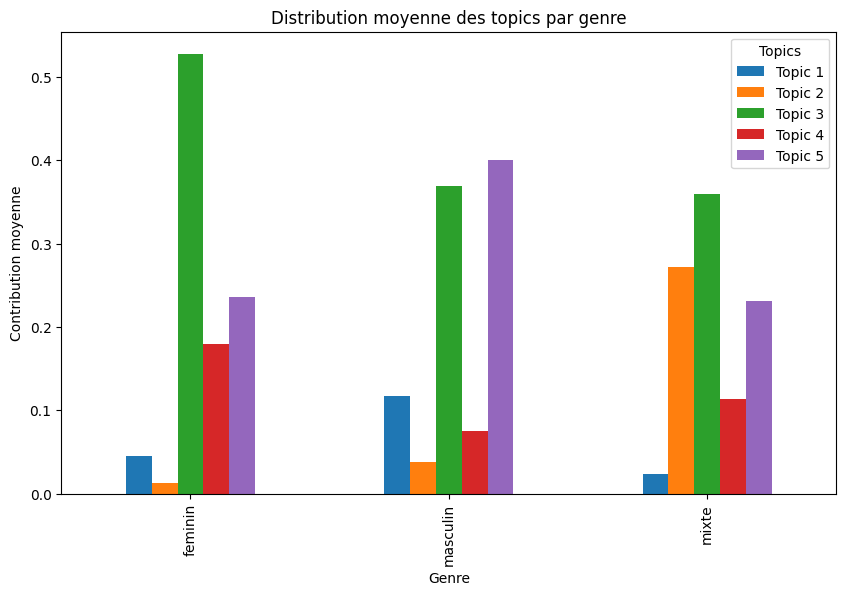

In [61]:
import matplotlib.pyplot as plt

mean_topics_by_genre.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution moyenne des topics par genre")
plt.ylabel("Contribution moyenne")
plt.xlabel("Genre")
plt.legend(title="Topics")
plt.show()


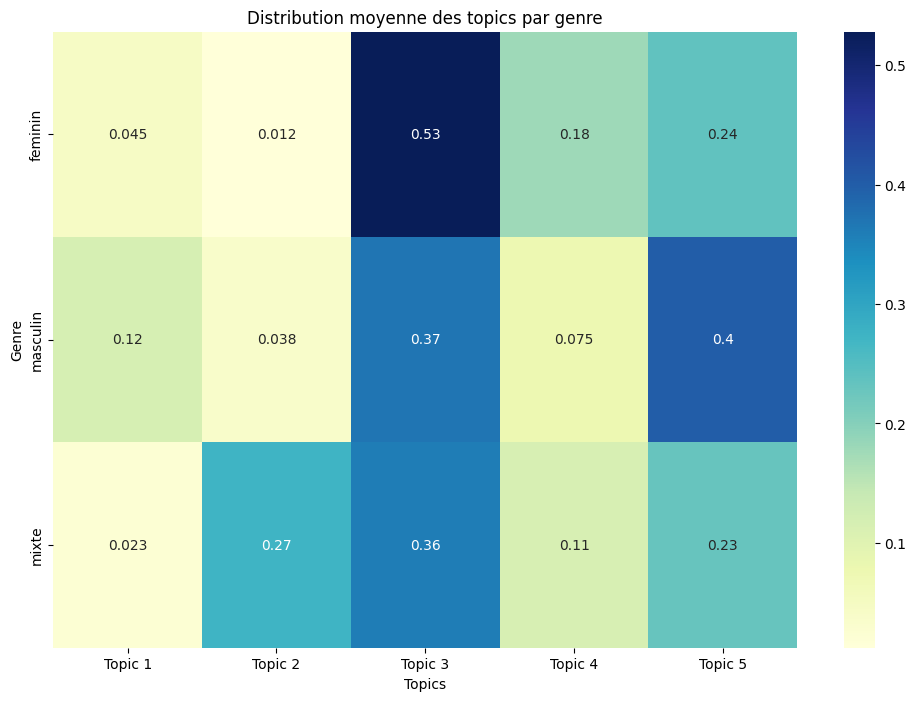

In [62]:
import seaborn as sns

# Heatmap de la distribution moyenne des topics par genre
plt.figure(figsize=(12, 8))
sns.heatmap(mean_topics_by_genre, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Distribution moyenne des topics par genre")
plt.ylabel("Genre")
plt.xlabel("Topics")
plt.show()